In [1]:
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
import scipy
import math
import imageio
import json
import time

from collections import Counter
from matplotlib.pyplot import figure
from matplotlib import animation

from Bio.PDB import *
import nglview as nv
import math
import warnings
from Bio.PDB.StructureBuilder import PDBConstructionWarning
warnings.filterwarnings("ignore", category=PDBConstructionWarning)

# this is dangerous of course but uncomment it when you want to run the code
# warnings.filterwarnings("ignore")

from Bio import SeqIO
from Bio import pairwise2
from Bio.pairwise2 import format_alignment



# seg_dir = "C:\Users\Kevin\Documents\TDA\afrl\Segmentations"
# seg_dir = "C:/Users/Kevin/Documents/TDA/afrl/Segmentations"
seg_dir = "../Batch_protein_all_5_3_no_na.csv_2019.07.08 16.10/"

In [2]:
# aaron's code to make sure the folders are all in their proper place

dirlocal = os.path.curdir
data_path = os.path.join(dirlocal, 'Data/')
protein_path = os.path.join(data_path, 'Proteins/')
pdb_path = os.path.join(data_path, 'PDB/')
fasta_path = os.path.join(data_path, 'fasta/')
dssp_path = os.path.join(data_path, 'DSSP/')

if not os.path.exists(data_path):
    os.makedirs(data_path)
if not os.path.exists(protein_path):
    os.makedirs(protein_path)
if not os.path.exists(pdb_path):
    os.makedirs(pdb_path)
ss_path = os.path.join(data_path, 'ss.txt')
feature_path = os.path.join(data_path, 'sample-input-features.npy')
distance_path = os.path.join(data_path, 'sample-distance-maps-cb.npy')
full_feature_path = os.path.join(data_path, 'full-input-features.npy')
full_distance_path = os.path.join(data_path, 'full-distance-maps-cb.npy')
test_feature_path = os.path.join(data_path, 'testset-input-features.npy')
test_distance_path = os.path.join(data_path, 'testset-distance-maps-cb.npy')


In [3]:
## aaron's code to get raw features from pdb

import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import figure
%matplotlib inline
import time
import requests
import xml.etree.ElementTree as ET

# ! pip install biopython
# ! pip install nglview
# ! jupyter-nbextension enable nglview --py --sys-prefix

from Bio.PDB import *
import nglview as nv
import math
import warnings
from Bio.PDB.StructureBuilder import PDBConstructionWarning
warnings.filterwarnings("ignore", category=PDBConstructionWarning)

# this is dangerous of course but uncomment it when you want to run the code
# warnings.filterwarnings("ignore")

from Bio import SeqIO
from Bio import pairwise2
from Bio.pairwise2 import format_alignment


In [4]:
def fix_chip_start_stop(df, step_size, chip_size):

    ch=[int(x.split("_")[-1]) for x in df['chip_id']]

    start=[c*step_size for c in ch]
    stop=[chip_size+c*step_size for c in ch]

    df['start']=start
    df['stop']=stop
    
    return df

In [5]:
###  aaron's functions: 

# gets dataframe containing torsion angles, peptides, chain, etc
# from pdb file
def get_torsion_angles(pdb_id, degrees=False):
    pdb_struct = get_pdb_structure(pdb_id)
    torsion_angles = []
    for model in pdb_struct:
        for chain in model:
            polypeptides = PPBuilder().build_peptides(chain)
            for poly_index, poly in enumerate(polypeptides):
                #print("Model %s Chain %s" % (str(model.id), str(chain.id)))
                #print("(part %i of %i)" % (poly_index+1, len(polypeptides)))
                #print("length %i" % (len(poly)))
                #print("from %s%i" % (poly[0].resname, poly[0].id[1]))
                #print("to %s%i" % (poly[-1].resname, poly[-1].id[1]))
                phi_psi = poly.get_phi_psi_list()
                for res_index, residue in enumerate(poly):
                    res_name = "%s%i" % (residue.resname, residue.id[1])
                    #print(res_name, tuple(math.degrees(b) for b in phi_psi[res_index] if b))
                    deg = phi_psi[res_index]
                    if degrees:
                        deg = tuple(math.degrees(b) if b else None for b in deg)
                    phi, psi = deg
                    model_name, model_id = model.full_id
                    torsion_angles.append([model_name, model_id, chain.id, residue.resname, residue.id[1], phi, psi])
    return pd.DataFrame(torsion_angles, columns=['Model_Name', 'Model_ID', 'Chain', 'Residue_Name', 'Residue_ID', 'Phi', 'Psi'])


# generates ramachandran plot from a given pdb file
def ramachandran_plot(pdb_id, degrees=True):
    df = get_torsion_angles(pdb_id, degrees)
    x = df['Phi']
    y = df['Psi']
    # Generate plot
    plt.plot(x, y, ".")
    plt.title('Ramachandran Plot')
    if degrees:
        plt.xlabel(f'$\Phi$ Angle (Degrees)')
        plt.xlim(-180, 180)
        plt.ylabel(f'$\Psi$ Angle (Radians)')
        plt.ylim(-180, 180)
        plt.show()
    else:
        plt.xlabel(f'$\Phi$ Angle (Radians)')
        plt.xlim(-math.pi, math.pi)
        plt.ylabel(f'$\Psi$ Angle (Radians)')
        plt.ylim(-math.pi, math.pi)
        plt.show()

# helper function which generates a biopython structure
# for display in display_protein()
def get_pdb_structure(pdb_id):
    pdb_id = pdb_id.upper()
    parser = PDBParser()
    file_path = os.path.join(pdb_path, f"{pdb_id}.pdb")
    try:
        struct = parser.get_structure(pdb_id, file_path)
    except Exception as e:
        print(e)
        return None
    return struct


#  downloads the protein in question from pdb
def get_pdb_file(pdb_id, replace=False):
    pdb_id = pdb_id.upper()
    file_path = os.path.join(pdb_path, f'{pdb_id}.pdb')
    if os.path.isfile(file_path) and not replace:
        return True
    parser = PDBParser()
    url = f'https://files.rcsb.org/download/{pdb_id}.pdb'
    resp = requests.get(url)
    try:
        #print(file_path)
        file = open(file_path, "wb")
        file.write(resp.content)
        file.close()
    except Exception as e: 
        print(e)
        return False
    return True

# neato 3d viewer of a protein's structure
def display_protein(pdb_id):
    pdb_struct = get_pdb_structure(pdb_id)
    view = nv.show_biopython(pdb_struct)
    return view


#  returns a dataframe with secondary structure, amino acid code, chain id, etc
# deprecated
def get_secondary_structure(pdb_id):
    pdb_id = pdb_id.upper()
    indexes = get_pdb_ss_seq(pdb_id)
    chain_df = []
    for i, chain_ss in enumerate(indexes):
        chain_id, seq, ss = chain_ss
        #unknown_list = [i for i, c in enumerate(seq) if c == 'X']
        #print(unknown_list)
        seq_list = [c for c in seq]
        # [f(x) if condition else g(x) for x in sequence]
        ss_list = ['L' if c is ' ' else c for c in ss]
        #print(seq_list + ss_list)
        chain_df.append(pd.DataFrame({'Chain': chain_id, 'Amino_Acid':seq_list, 'Secondary_Structure':ss_list}))
    return pd.concat(chain_df)

# get matrix of pairwise carbon beta distances
def get_cb_distances(full_pdb_id, partial=False):
    pdb_id = full_pdb_id[0:4].upper()
    get_pdb_file(pdb_id)
    pdb_struct = get_pdb_structure(pdb_id)  # Returns the BioPython structure of the PDB file
    ppb = PPBuilder()
    chain_dist_matrix = {}
    for model in pdb_struct:
        for chain in model:
            if chain.id == full_pdb_id[4] and partial:
                residues = []
                for pp in ppb.build_peptides(chain, aa_only=False):
                    for residue in pp:
                        residues.append(residue)
                lng = len(residues)
                dist_matrix = np.zeros((lng, lng), np.float)
                for i in range(0, lng):
                    for j in range(i, lng):
                        try:
                            diff_vector  = residues[i]['C'].coord - residues[j]['C'].coord
                        except Exception:
                            # This just gets the average value around the unknown residue distance
                            count = 0
                            sums = 0
                            if j - 1 > 0:
                                count += 1
                                sums += dist_matrix[i][j - 1]
                            if i - 1 > 0:
                                count += 1
                                sums += dist_matrix[i - 1][j]
                            if count > 0:
                                diff_vector = sums / count
                            else:
                                diff_vector = 0
                        dist = np.sqrt(np.sum(diff_vector * diff_vector))
                        dist_matrix[i][j] = dist
                        dist_matrix[j][i] = dist
                    chain_dist_matrix = dist_matrix
        
    if partial:
        start_pos, end_pos, bool_arr = get_seq_pos(full_pdb_id)
        if start_pos == -1:
            return pd.DataFrame(chain_dist_matrix[bool_arr]).iloc[:, bool_arr]
        return pd.DataFrame(chain_dist_matrix[start_pos:end_pos]).iloc[:, start_pos:end_pos]
    else:
        return chain_dist_matrix
    
    
# gets alignment of given sequence on top of the original sequence
# from a fasta file downloaded from the cloud repository
def get_seq_alignment(full_pdb_id):
    seq = ''
    for record in SeqIO.parse(os.path.join(fasta_path, f'{full_pdb_id}.fasta'), "fasta"):
        seq = record.seq
    pdb_id = full_pdb_id[0:4].upper()
    #print(pdb_id)
    get_pdb_file(pdb_id)
    struct = get_pdb_structure(pdb_id)
    ppb = PPBuilder()
    for model in struct:
        for chain in model:
            if chain.id == full_pdb_id[4]:
                ground_seq = ''
                for pp in ppb.build_peptides(chain, aa_only=False):
                    ground_seq += pp.get_sequence()
                alignments = pairwise2.align.globalxx(ground_seq, str(seq))
                al_seq = alignments[0][1]
                al_seq_bool = [False if a is '-' else True for a in al_seq]
                return al_seq_bool

            
def get_seq_pos(full_pdb_id):
    seq = ''
    for record in SeqIO.parse(os.path.join(fasta_path, f'{full_pdb_id}.fasta'), "fasta"):
        seq = str(record.seq)
    pdb_id = full_pdb_id[0:4].upper()
    get_pdb_file(pdb_id)
    struct = get_pdb_structure(pdb_id)
    ppb = PPBuilder()
    for model in struct:
        for chain in model:
            if chain.id == full_pdb_id[4]:
                ground_seq = ''
                for pp in ppb.build_peptides(chain, aa_only=False):
                    ground_seq += pp.get_sequence()
                start_pos = ground_seq.find(seq)
                if start_pos == -1:
                    alignments = pairwise2.align.globalxx(ground_seq, seq)
                    al_seq = alignments[0][1]
                    bool_seq = [False if a == '-' else True for a in al_seq]
                    #start_pos = largest_substring_pos(ground_seq, seq)
                    #start_pos = int(alignments[0][2] - 1)
                    #end_pos = start_pos + len(al_seq)
                    return (-1, -1, bool_seq)
                else:
                    end_pos = start_pos + len(seq)
                    return (start_pos, end_pos, '')


            
            
# calls dssp api to get dssp file
def pdb_id_to_dssp_file(pdb_id, replace=False):
    pdb_id = pdb_id.upper()
    rest_url = 'http://www.cmbi.umcn.nl/xssp/'
    # Read the pdb id data into a variable
    data = {'data': pdb_id}

    # Send a request to the server to create hssp data from the pdb file data.
    # If an error occurs, an exception is raised and the program exits. If the
    # request is successful, the id of the job running on the server is
    # returned.
    url_create = f'{rest_url}api/create/pdb_id/dssp/'
    r = requests.post(url_create, data=data)
    r.raise_for_status()

    job_id = json.loads(r.text)['id']
    #print(f'Job submitted successfully. Id is: {job_id}')

    # Loop until the job running on the server has finished, either successfully
    # or due to an error.
    ready = False
    while not ready:
        # Check the status of the running job. If an error occurs an exception
        # is raised and the program exits. If the request is successful, the
        # status is returned.
        url_status = f'{rest_url}api/status/pdb_id/dssp/{job_id}/'
        r = requests.get(url_status)
        r.raise_for_status()

        status = json.loads(r.text)['status']
        #print(f'Job status is: {status}')

        # If the status equals SUCCESS, exit out of the loop by changing the
        # condition ready. This causes the code to drop into the `else` block
        # below.
        #
        # If the status equals either FAILURE or REVOKED, an exception is raised
        # containing the error message. The program exits.
        #
        # Otherwise, wait for five seconds and start at the beginning of the
        # loop again.
        if status == 'SUCCESS':
            ready = True
        elif status in ['FAILURE', 'REVOKED']:
            raise Exception(json.loads(r.text)['message'])
        else:
            time.sleep(5)
    else:
        # Requests the result of the job. If an error occurs an exception is
        # raised and the program exits. If the request is successful, the result
        # is returned.
        url_result = f'{rest_url}api/result/pdb_id/dssp/{job_id}/'
        r = requests.get(url_result)
        r.raise_for_status()
        result = json.loads(r.text)['result']
        try:
            file_path = os.path.join(dssp_path, f'{pdb_id}.dssp')
            if os.path.isfile(file_path) and not replace:
                return True
            #print(file_path)
            file = open(file_path, "w")
            file.write(result)
            file.close()
        except Exception as e: 
            print(e)
            return False
        # Return the result to the caller, which prints it to the screen.
        return True

# uses api call file to generate secondary structure, phi/psi, solvent-accessibility stuff
# because of indexing stuff, it crashes if we use partial = True
# ask aaron about that
def get_ground_truth_api(full_pdb_id, partial=False):
    pdb_id = full_pdb_id[0:4].upper()
    get_pdb_file(pdb_id)
    struct = get_pdb_structure(pdb_id)
    ppb = PPBuilder()
    struct_info = []
    for model in struct:
        file = os.path.join(pdb_path, f'{pdb_id}.pdb')
        pdb_id_to_dssp_file(pdb_id)
        dssp = DSSP(model=model, in_file=os.path.join(dssp_path, f'{pdb_id}.dssp'), file_type='DSSP')
        seq_count = 0
        #dssp = DSSP(model=model, in_file=file)
        for chain in model:
            if chain.id == full_pdb_id[4] or not partial:
                residues = []
                seq = ''
                for pp in ppb.build_peptides(chain, aa_only=False):
                    seq += pp.get_sequence()
                    for residue in pp:
                        residues.append(residue)
                for i, residue in enumerate(residues):
                    try:
                        key = list(dssp.keys())[seq_count]   
                        dssp_info = dssp[key]
                        amino_acid = dssp_info[1]
                        sec_struct = dssp_info[2]
                        solv_acc = dssp_info[3]
                        phi = dssp_info[4]
                        psi = dssp_info[5]
                    except Exception:
                        # DSSP didn't capture this amino acid
                        #print(full_pdb_id, seq_count, len(dssp), len(seq), residue)
                        amino_acid = seq[i]
                        sec_struct = '-'
                        solv_acc = 0
                        phi = 360
                        psi = 360
                    seq_count += 1
                    # Keys 6 through 13 is bonding energy / relidx (no clue what this is)
                    struct_info.append([model.full_id[0], model.full_id[1], chain.id,
                        residue.resname, residue.id[1], amino_acid, sec_struct, solv_acc, phi, psi])
    info_df = pd.DataFrame(struct_info, 
        columns=['Model_Name', 'Model_ID', 'Chain', 'Residue_Name',
        'Residue_ID', 'Amino_Acid', 'Secondary_Structure', 'Solvent_Accessability', 
        'Phi', 'Psi'])
    if partial:    
        start_pos, end_pos, bool_arr = get_seq_pos(full_pdb_id)
        if start_pos == -1:
            return info_df[bool_arr]
        return info_df[start_pos:end_pos]
    else:
        return info_df


    
# the following two functions download the files from the api
# to create a cache on the disk
# speeds things up immensely, only need to run once though
def get_ground_truth_files(full_pdb_id, replace=False, partial=False):
    bad_list = ['4osnA0']
    if full_pdb_id in bad_list:
        return 'Bad File'
    if partial:
        file_path = os.path.join(protein_path, full_pdb_id + '.csv')
    else:
        file_path = os.path.join(protein_path, full_pdb_id[0:4] + '.csv')
        
    if os.path.isfile(file_path) and not replace:
        return True
    
    df = get_ground_truth(full_pdb_id, partial)
    file_path = ''
    try:
        df.to_csv(file_path)
    except Exception:
        return False
    return True
    
def get_cb_distance_files(full_pdb_id, replace=False, partial=False):
    bad_list = ['4osnA0']
    if full_pdb_id in bad_list:
        return 'Bad File'
    file_path = ''
    if partial:
        file_path = os.path.join(distances_path, full_pdb_id + '.csv')
        if os.path.isfile(file_path) and not replace:
            return True
        try:
            df = get_cb_distances(full_pdb_id, partial)
            df.to_csv(file_path)
        except Exception:
            return False
        return True
    else:
        df = get_cb_distances(full_pdb_id, partial)
        keys = df.keys
        for key in keys:
            file_path = os.path.join(distances_path, full_pdb_id[0:4] + key + '0.csv')
            if os.path.isfile(file_path) and not replace:
                return True
            try:
                df[key].to_csv(file_path)
            except Exception:
                return False
        return True


In [6]:
dataset_25=pandas.read_csv("datasets/protein_all_25_12_no_na.csv")
dataset_10=pandas.read_csv("datasets/protein_all_10_5_no_na.csv")
dataset_5=pandas.read_csv("datasets/protein_all_5_3_no_na.csv")

fix_chip_start_stop(dataset_25,12,25)
fix_chip_start_stop(dataset_10,5,10)
fix_chip_start_stop(dataset_5,3,5)


pdb_list, length_dict, aa_seq, input_features = np.load("datasets/testset-input-features.npy",allow_pickle=True)
pdb_list_y, distance_maps_cb = np.load("datasets/testset-distance-maps-cb.npy",encoding="latin1",allow_pickle=True)



In [7]:
# functions
def get_rows_from_segmentation(seg, dataset):
    with open(seg_dir+seg) as jsonf:
        a=json.load(jsonf)
        df=dataset.iloc[[int(m) for m in a['rows']],:]
        return df


In [8]:

def draw_ss_predicts(index,ss):
    
#     H, G and I to H; E to E; the rest to C
    ss_dict={
        "H":0,
        "G":0,
        "I":0,
        "E":1,
        "B":2,
        "T":2,
        "S":2             
            }
    
    aa_length=length_dict[pdb_list[index]]
    
    plt.figure(figsize=(15,10))

    df25=dataset_25[dataset_25["protein_id"]==dataset_25["protein_id"].unique()[index]] 
    df10=dataset_10[dataset_10["protein_id"]==dataset_10["protein_id"].unique()[index]] 
    df5=dataset_5[dataset_5["protein_id"]==dataset_5["protein_id"].unique()[index]] 

    plt.subplot(4,1,1)
    y=ground_truth_window_avg(df5)["ground_truth_"+ss]
    x=range(0,len(y))
    plt.bar(x,y,1)
    plt.xlim((0,aa_length))    

    plt.subplot(4,1,2)
    y=ground_truth_window_avg(df10)["ground_truth_"+ss]
    x=range(0,len(y))
    plt.bar(x,y,1)
    plt.xlim((0,aa_length))

    plt.subplot(4,1,3)
    y=ground_truth_window_avg(df25)["ground_truth_"+ss]
    x=range(0,len(y))
    plt.bar(x,y,1)
    plt.xlim((0,aa_length))

    plt.subplot(4,1,4)
    y=[1-n for n in input_features[pdb_list[index]][ss_dict[ss]].astype(np.float)]
    x=range(0,len(y))
    plt.bar(x,y,1)
    plt.xlim((0,aa_length))

    
    
def get_inv_psipred_from_ss(protein):
#     H to H; E to E; the rest to C
    ss_dict={
        "H":0,
        "G":0,
        "I":0,
        "E":1,
        "B":1,
        "T":2,
        "S":2,
        "-":2
            }
    
    # I subtract it from 1 to make it on the same scale as the other predictions
    # (i.e. high means more likely to be X)
    
    return [1-n for n in input_features[protein][ss_dict[ss]].astype(np.float)]


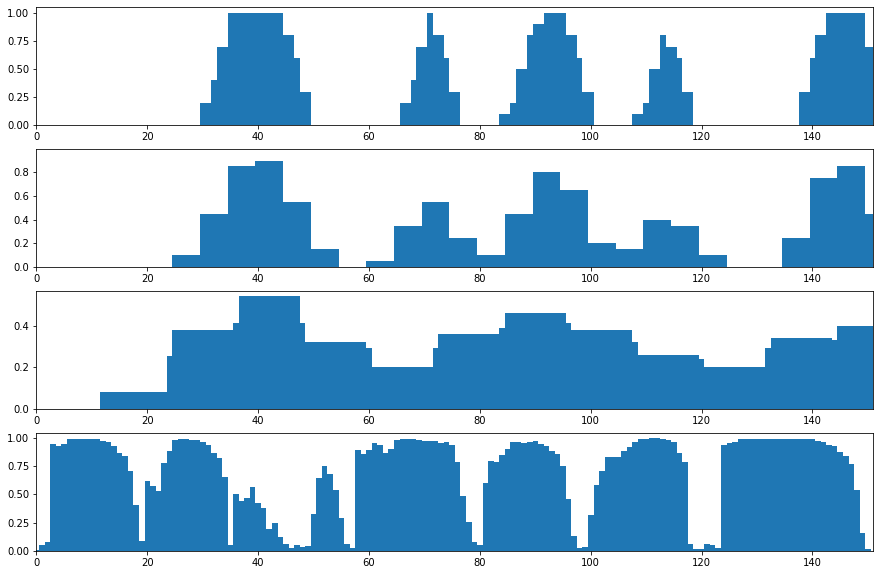

In [12]:
# "HBEGITS"
draw_ss_predicts(1,"H")

In [9]:
def get_reduced_ss(protein_id):
    ss_file=os.path.join(data_path,"ss",protein_id+".ss")
    sf=open(ss_file).read()
    return(list(sf.split("\n")[1]))
   
# get_reduced_ss("1bebA")

In [10]:
def ground_truth_window_avg(df):
    aa_length=max(df["stop"])
    mean_ss=[]
    gt=["ground_truth_"+ss for ss in "HBEGITS"]

    for aa in range(0,aa_length):
        chip=df[(df["start"]<=aa) & (df["stop"]>aa)]
        mean_ss.append(chip[gt].mean(0))
    gt_avg=pandas.DataFrame(mean_ss)
    
    return gt_avg


In [45]:
# for each protein:
#     for chip in protein
#         get avg ss's for chip
#     get avg ss for each aa
#     get psipred for each aa
#     present as bar graph

#     get gt for protein !!!!

#     get thd_rmse for protein
#     get psipred_rmse for protein
#     put rmse's in vectors

# graph rmse's

# the following is pseudocode

def rmse(a,b):
    return np.sqrt(np.mean((a-b)**2))

def eval_test_data_new(leaf_df,dataset):
    output_df=pandas.DataFrame()
    
    for protein in pandas.unique(leaf_df['protein_id']):
        print(protein)
        mean_ss=[]
        gt_names=["pred_gt_"+ss for ss in "HBEGITS"]

        # this part is avg'ing across the wrong stuff
        # all the values end up the same
        
        for aa in range(length_dict[protein]):
            chip=leaf_df[(leaf_df["start"]<=aa) & (leaf_df["stop"]>aa)]
            mean_ss.append([protein]+list(chip[gt_names].mean(0)))
        gt_avg=pandas.DataFrame(mean_ss)
        gt_avg.columns=["protein_id"]+["pred_ss_"+ss for ss in "HBEGITS"]
        
        
        ssgt=[]
        
        for sec_s in "HBEGITS":
        # get gt for protein
            ss=get_ground_truth_api(protein)['Secondary_Structure']
            gt=[int(x) for x in ss==sec_s]
            gt_avg["ground_truth_"+sec_s]=gt
            
        gt_avg['psipred_helix']=input_features[protein][0].astype(np.float)
        gt_avg['psipred_sheet']=input_features[protein][1].astype(np.float)
        gt_avg['psipred_coil']=input_features[protein][2].astype(np.float)
        
        output_df.append(gt_avg)
    return output_df

    
def eval_test_data_reduced(leaf_df,dataset):
    output_df=pandas.DataFrame()
    
    for protein in pandas.unique(leaf_df['protein_id']):
        print(protein)
        mean_ss=[]
        gt_names=["thd_pred_helix","thd_pred_sheet","thd_pred_coil"]

        # this part is avg'ing across the wrong stuff
        # all the values end up the same
        
        for aa in range(length_dict[protein]):
            chip=leaf_df[(leaf_df["start"]<=aa) & (leaf_df["stop"]>aa)]
            mean_ss.append([protein,aa]+list(chip[gt_names].mean(0)))
        gt_avg=pandas.DataFrame(mean_ss)
        gt_avg.columns=["protein_id","aa_index"]+["pred_ss_"+ss for ss in "HEC"]
        
        
        ssgt=[]
        
        for sec_s in "HEC":
        # get gt for protein
            ss=get_reduced_ss(protein)
            gt=[int(x==sec_s) for x in ss]
            gt_avg["ground_truth_"+sec_s]=gt
            
        gt_avg['psipred_helix']=input_features[protein][0].astype(np.float)
        gt_avg['psipred_sheet']=input_features[protein][1].astype(np.float)
        gt_avg['psipred_coil']=input_features[protein][2].astype(np.float)
        
        gt_avg['inv_psipred_helix']=1-input_features[protein][0].astype(np.float)
        gt_avg['inv_psipred_sheet']=1-input_features[protein][1].astype(np.float)
        gt_avg['inv_psipred_coil']=1-input_features[protein][2].astype(np.float)
 
        
        output_df=output_df.append(gt_avg)
        
    return output_df

    
    
def seg_rows_formatted(thd_name,file_id,dataset):
    seg="GROUPDATA_"+thd_name+" "+file_id+".json"
    return get_rows_from_segmentation(thd_name+"/"+seg,dataset)


In [12]:
def add_pred_gt(leafdf,dataset):

    gt=["ground_truth_"+ss for ss in "HBEGITS"]

    ss_pred=pandas.DataFrame()

    for index, row in leafdf.iterrows():
        ssp=seg_rows_formatted(row['thd_id'],row['file_id'],dataset)[gt].mean(0)
        ss_pred=ss_pred.append(ssp, ignore_index=True)
        
    ss_pred.columns=["pred_gt_"+ss for ss in "HBEGITS"]
    return pandas.concat([leafdf,ss_pred],axis=1)

def add_pred_condensed(leafdf,dataset):
    
    ss_dict={
        "H":0,
        "G":0,
        "I":0,
        "E":1,
        "B":1,
        "T":2,
        "S":2,
        "-":2
    }
    
    gt=["ground_truth_"+ss for ss in "HBEGITS"]

    ss_pred=pandas.DataFrame()

    for index, row in leafdf.iterrows():
        ssp=seg_rows_formatted(row['thd_id'],row['file_id'],dataset)[gt]
        
        helix=["ground_truth_"+ss for ss in "HGI"]
        sheet=["ground_truth_"+ss for ss in "EB"]
        coil=["ground_truth_"+ss for ss in "TS"]

        hlx=ssp[helix].sum(axis=1)
        sh=ssp[sheet].sum(axis=1)
        cl=1-(hlx+sh)

        pred=pandas.concat([hlx,sh,cl],axis=1)

        ss_pred=ss_pred.append(pred.mean(axis=0),ignore_index=True)
    ss_pred.columns=["thd_pred_helix","thd_pred_sheet","thd_pred_coil"]
    return pandas.concat([leafdf,ss_pred],axis=1)




In [13]:
thd_leafs=add_pred_condensed(pandas.read_csv("datasets/test6_sequences_pred.csv"),dataset_5)

In [46]:

# ignore=['1bebA']

# leafs_new=thd_leafs[[x not in ignore for x  in list(thd_leafs['protein_id'])]]



prediction_df=eval_test_data_reduced(thd_leafs,dataset_5)


# 1rybA

# len(input_features['1bebA'][0])
# length_dict['1bebA']

1rybA
1bebA
1d4oA
1fx2A
1tzvA
1m4jA
1gbsA
1nrvA
1w0hA
2arcA
1qjpA
1cznA
1ihzA
1a70A
1k7cA
1kw4A
1gz2A
1vp6A
1h4xA
1lm4A
1f6bA
1dixA
1jbkA
1ny1A
1jo8A
1smxA
1bdoA
3dqgA
1i1nA
2phyA
1rw1A
1cc8A
1jl1A
1ag6A
1jo0A
1dmgA
1wjxA
1h2eA
1jwqA
1tqgA
1lo7A
1mk0A
1tifA
1k6kA
1p90A
1behA
1hh8A
1im5A
1d1qA
1i58A
1i4jA
1gmiA
1jkxA
1a3aA
1fvkA
1svyA
1npsA
1c9oA
1fl0A
1dlwA
1bkrA
1cjwA
1atzA
5ptpA
2tpsA
1jfxA
1eazA
2hs1A
1xkrA
1iibA
1h98A
1wkcA
1vjkA
1i71A
1hfcA
1xdzA
1avsA
1dbxA
1ek0A
1iwdA
1roaA
1bsgA
1jvwA
1qf9A
1a6mA
1kidA
1whiA
1d0qA
1kqrA
1m8aA
1ckeA
3borA
1fqtA
1gmxA
1k7jA
1ne2A
1brfA
1ql0A
1fnaA
1o1zA
1h0pA
1t8kA
1i1jA
1vfyA
1fcyA
1vhuA
1pchA
1guuA
1jfuA
1kq6A
1hdoA
1gzcA
1aapA
1dsxA
1g9oA
1dqgA
1nb9A
2cuaA
1atlA
1hxnA
1ctfA
1lpyA
1aoeA
1i5gA
1tqhA
1g2rA
1mugA
2mhrA
1abaA
1j3aA
2vxnA
1cxyA
1r26A
1c44A
1c52A
1ktgA
1jyhA
1chdA
1fvgA
1ej8A
1rw7A
1ku3A
1htwA
1vmbA
1josA
1fk5A
1ej0A
1xffA
1jbeA
1pkoA


In [48]:
prediction_df.to_csv("data/reduced_predict.csv")

In [47]:
# this gives us a table of the accuracy results

rmse_df=pandas.DataFrame()

psipred=["inv_psipred_helix","inv_psipred_sheet","inv_psipred_coil"]

results_df=pandas.DataFrame()

for ss in range(3):
    
    pred="pred_ss_"+"HEC"[ss]
    gt="ground_truth_"+"HEC"[ss]
    psi=psipred[ss]
    
    rmse_pred=rmse(prediction_df[pred],prediction_df[gt])
    acc_pred=1-np.mean(abs(prediction_df[pred]-prediction_df[gt]))
    
    rmse_psi=rmse(prediction_df[psi],prediction_df[gt])
    acc_psi=1-np.mean(abs(prediction_df[psi]-prediction_df[gt]))
    
    row=[["helix","sheet","coil"][ss]]+[rmse_pred,acc_pred,rmse_psi,acc_psi]
    row=pandas.Series(row)
    results_df=results_df.append(row,ignore_index=True)

columns=["structure"]
columns+=["thd_pred_rmse","thd_pred_accuracy"]
columns+=["psipred_rmse","psipred_accuracy"]

results_df.columns=columns

results_df
    
# see sequence graphed on all classes
#      because ryan wants to know how to threshhold it
# accuracy for the aa that are helices
# add a none % column

,structure,thd_pred_rmse,thd_pred_accuracy,psipred_rmse,psipred_accuracy
0,helix,0.475236,0.542543,0.485416,0.656630
1,sheet,0.430479,0.637550,0.647177,0.531114
2,coil,0.492306,0.517255,0.625845,0.546249


In [15]:
prediction_df

,protein_id,aa_index,pred_ss_H,pred_ss_E,pred_ss_C,ground_truth_H,ground_truth_E,ground_truth_C,psipred_helix,psipred_sheet,psipred_coil
0,1rybA,0,0.378177,0.232634,0.389189,0,0,1,0.998,0.000,0.004
1,1rybA,1,0.403345,0.228695,0.367960,0,0,1,0.930,0.003,0.059
2,1rybA,2,0.397201,0.234217,0.368582,0,0,1,0.803,0.001,0.193
3,1rybA,3,0.389086,0.231087,0.379826,0,1,0,0.153,0.001,0.846
4,1rybA,4,0.376399,0.228785,0.394816,0,1,0,0.019,0.001,0.980
5,1rybA,5,0.363242,0.234535,0.402223,0,1,0,0.011,0.001,0.989
6,1rybA,6,0.350897,0.240686,0.408417,0,1,0,0.022,0.001,0.980
7,1rybA,7,0.350535,0.231274,0.418190,0,1,0,0.192,0.001,0.815
8,1rybA,8,0.354127,0.235721,0.410152,0,0,1,0.468,0.001,0.592
9,1rybA,9,0.358658,0.234837,0.406504,0,0,1,0.898,0.002,0.133


In [72]:
# thd_leafs[thd_leafs['protein_id']=="1bebA"]

# input_features["1bebA"]

[array(['0.995', '0.959', '0.952', '0.943', '0.948', '0.926', '0.951',
        '0.736', '0.783', '0.617', '0.195', '0.231', '0.187', '0.121',
        '0.047', '0.033', '0.089', '0.032', '0.010', '0.008', '0.015',
        '0.134', '0.689', '0.920', '0.594', '0.516', '0.523', '0.444',
        '0.421', '0.506', '0.873', '0.972', '0.972', '0.926', '0.571',
        '0.181', '0.064', '0.032', '0.017', '0.012', '0.009', '0.021',
        '0.020', '0.102', '0.964', '0.964', '0.969', '0.892', '0.606',
        '0.075', '0.019', '0.010', '0.009', '0.010', '0.010', '0.045',
        '0.214', '0.243', '0.980', '0.974', '0.481', '0.106', '0.021',
        '0.009', '0.013', '0.022', '0.026', '0.034', '0.081', '0.060',
        '0.148', '0.809', '0.943', '0.965', '0.915', '0.537', '0.111',
        '0.054', '0.025', '0.050', '0.315', '0.726', '0.937', '0.900',
        '0.788', '0.695', '0.074', '0.016', '0.009', '0.008', '0.031',
        '0.199', '0.759', '0.977', '0.964', '0.839', '0.705', '0.122',
      